## Modeling Laptop Prices

We continue with our goal of taking some key laptop features and using them to discover whethere there are any trends or grouping to laptop pricing. Ideally, we find a model that can accurately portray our laptop pricing data and give us an idea of what features matter the most to our customers. In this way, we can accurately price any new releases and focus on developing a laptop with features that our consumers care about. We want to avoid overcharging for features that consumers have no interest which would lead to lower sales. We also want to make sure our supply matches consumer needs and thus increase our sales by giving consumers their ideal laptop at the right price point.

Our next step moving forward will be to test out some models. We will be running through the pre-processing steps here that was done in a previous notebook and then implement that dataframe into our models.

Let us start by importing the foundational packages needed and then move on to setting the stage for our data.

In [1]:
# Necessary imports
#The foundation
#The models will be imported as needed
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading our data!
laptop_data = pd.read_csv('../dataset/tim_laptop_cleaned.csv', index_col = 0)

# Checking our data tyes and the size of our dataframe
laptop_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 896 entries, 0 to 895
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            896 non-null    object 
 1   model            896 non-null    object 
 2   processor_brand  896 non-null    object 
 3   processor_name   896 non-null    object 
 4   processor_gnrtn  896 non-null    object 
 5   ram_gb           896 non-null    int64  
 6   ram_type         896 non-null    object 
 7   ssd_gb           896 non-null    int64  
 8   hdd_gb           896 non-null    int64  
 9   os               896 non-null    object 
 10  os_bit           896 non-null    int64  
 11  graphic_card_gb  896 non-null    int64  
 12  weight           896 non-null    object 
 13  display_size     896 non-null    object 
 14  warranty         896 non-null    int64  
 15  msoffice         896 non-null    object 
 16  latest_price     896 non-null    float64
dtypes: float64(1), i

From our previous exploration, we know that there is some work to be done with these data types. The model column in particular is extremely diverse and does not offer a lot of meaningful information as it is spread so thing across the categories. There are also some missing values in the columns `processor_gnrtn` and `display_size` that we will need to impute so we can use the data. The following cells will manage that for us.

In [3]:
#Dropping the model column from our data as it was too extraneous
laptop_df = laptop_data.drop(['model'], axis = 1)

#Replace the string 'Missing' with NaN so we can properly impute
laptop_df = laptop_df.replace('Missing', np.nan)
laptop_df.isna().sum()

brand                0
processor_brand      0
processor_name       0
processor_gnrtn    239
ram_gb               0
ram_type             0
ssd_gb               0
hdd_gb               0
os                   0
os_bit               0
graphic_card_gb      0
weight               0
display_size       332
warranty             0
msoffice             0
latest_price         0
dtype: int64

## 1. Data Preparation: Imputing, Dummy Variables, and Binarize

We are going to impute the `processor_gnrtn` and `display_size` so that we can keep that data otherwise we would have a lot of missing data. It also is reasonable to anticipate the "most common" models.

We will also binarize `warranty` because it is more useful to have two groups of "yes" and "no" instead of one group of "no" and multiple small groups of varying sizes. It would give us more warranty power.

Because not every model will require us to dummy-encode our categorical variables we will do so as needed.

In [4]:
#Imputing `process_gnrtn` with the mode of the column
laptop_df['processor_gnrtn'] = laptop_df['processor_gnrtn'].fillna(laptop_df['processor_gnrtn'].mode()[0])

# Convert the `display_size` to numeric quantity then impute with the mode
laptop_df['display_size'] = pd.to_numeric(laptop_df['display_size'])
laptop_df['display_size'] = laptop_df['display_size'].fillna(laptop_df['display_size'].mode()[0])

In [5]:
#Binarize and drop warranty
df = laptop_df
df['Binarize_Warranty'] = 0
df.loc[df['warranty'] > 0, 'Binarize_Warranty'] = 1

df = df.drop('warranty', axis = 1)

In [6]:
df.isna().sum()

brand                0
processor_brand      0
processor_name       0
processor_gnrtn      0
ram_gb               0
ram_type             0
ssd_gb               0
hdd_gb               0
os                   0
os_bit               0
graphic_card_gb      0
weight               0
display_size         0
msoffice             0
latest_price         0
Binarize_Warranty    0
dtype: int64

In [7]:
df.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd_gb,hdd_gb,os,os_bit,graphic_card_gb,weight,display_size,msoffice,latest_price,Binarize_Warranty
0,Lenovo,AMD,A6-9225 Processor,10th,4,DDR4,0,1024,Windows,64,0,ThinNlight,15.6,No,324.87,0
1,Lenovo,AMD,APU Dual,10th,4,DDR4,0,512,Windows,64,0,Casual,15.6,No,254.67,0
2,Avita,AMD,APU Dual,10th,4,DDR4,128,0,Windows,64,0,ThinNlight,15.6,No,259.87,0
3,Avita,AMD,APU Dual,10th,4,DDR4,128,0,Windows,64,0,ThinNlight,15.6,No,279.37,0
4,Avita,AMD,APU Dual,10th,4,DDR4,256,0,Windows,64,0,ThinNlight,15.6,No,324.87,0


In [8]:
df.shape

(896, 16)

## 2. Model Testing

We wil be testing out the following models: K-Mode Clustering, Isomapping, and XGBoost.

As we go through each mdoel, we will go through the reasoning for each. At the end, we will decide which model we believe to be the most useful for our needs and which model to go with.

Due to the high-dimensionality of our data and the extreme categorical/sparseness of it we have chosen to not use a linear model as it may not be an accurate representation of our goal.

## 2.1 K-Modes

We will first start with K-Modes. It is an extension of K-Means which allows us to study categorical variables. While K-Means finds cluster centers using the mean of the data, K-Modes uses the Mode of the data as a our centroid. That means we are able to utilize categorical dummy variables in order to analyse our data.

The k-prototypes model allows us to treat our categorical and numerical data equivalently. It does not require us to perform pre-processing on our categorical data so we will be scaling the data and adding it to our original data set.

We will create the dataset using the `df` dataframe that contains all of our data. We will scale our numerical data using MinMaxScaler to prevent huge distances between points and allow us to properly cluster. 

In [9]:
#Create the dataset -> We are working with clustering so no need to create a train/test set

X = df
X.shape

(896, 16)

In [10]:
#Scale our X accordingly using MinMaxScaler
X_to_scale = ['ram_gb', 'ssd_gb', 'hdd_gb', 'graphic_card_gb', 'display_size', 'latest_price']

#Initialize the MinMax Scaler
X_scaled = MinMaxScaler()

#Fit the X data for our numerical columns
X_scaled.fit(X[X_to_scale])

#Transform the X data for both the X_train and X_test
X_scaled = X_scaled.transform(X[X_to_scale])

#Convert these back to dataframes so we can add them back in
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns = X_to_scale)

In [11]:
#Add back in the columns
#All the other columns
X_other_columns = X.columns.drop(X_to_scale)

#Join from scaled to not-scaled
X = X_scaled.join(X[X_other_columns])

#Make sure we have no crazy join issues, we should have shape [896, 75] 
print(X.shape)

(896, 16)


In [12]:
X.columns

Index(['ram_gb', 'ssd_gb', 'hdd_gb', 'graphic_card_gb', 'display_size',
       'latest_price', 'brand', 'processor_brand', 'processor_name',
       'processor_gnrtn', 'ram_type', 'os', 'os_bit', 'weight', 'msoffice',
       'Binarize_Warranty'],
      dtype='object')

In [13]:
#Start with K-Mode Clustering from: https://github.com/nicodv/kmodes
#Install using conda install -c conda-forge kmodes (on anaconda)
from kmodes import kmodes, kprototypes

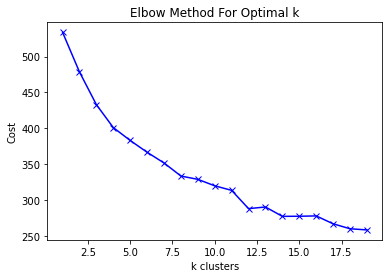

In [19]:
#We will initialize our model - documentation here: https://github.com/nicodv/kmodes/blob/master/kmodes/kprototypes.py
#We need to first see how many clusters would be ideal for our algorithm
#Also define the initialization method utilizing Cao's algorithm

cost =[]
K = range(1,20)
#categorical indices
categorical = list(range(6,16))
for num in list(K):
    kmodes = kprototypes.KPrototypes(n_clusters = num, init = 'Cao', n_init = 5);
    kmodes.fit_predict(X, categorical = categorical);
    cost.append(kmodes.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('k clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

### 2.1.1 Implement model

Based on the scree plot, we can see that 12 clusters seems to be the sweet spot for our k-prototype model. We will model using 12 clusters and look at where our centroids land. 

In [15]:
#It seems that 12 clusters is the ideal grouping for our data
kmodes = kprototypes.KPrototypes(n_clusters = 12, init = 'Cao', n_init = 5);
clusters = kmodes.fit_predict(X, categorical = categorical);

In [17]:
kmodes.cluster_centroids_

array([['0.1994851994851974', '0.17192192192192415', '0.0',
        '0.16891891891891891', '0.6488252958841237',
        '0.14012444219920817', 'ASUS', 'Intel', 'Core i5', '11th',
        'DDR4', 'Windows', '64', 'Casual', 'No', '1'],
       ['0.15510204081632648', '0.1327380952380953',
        '0.039285714285714285', '0.025', '0.5666666666666667',
        '0.1409604806408545', 'Lenovo', 'Intel', 'Core i5', '10th',
        'DDR4', 'Windows', '64', 'ThinNlight', 'No', '0'],
       ['0.07142857142857151', '0.08974358974358974',
        '0.1987179487179487', '0.003205128205128205',
        '0.603871292106586', '0.08117822909178048', 'DELL', 'Intel',
        'Core i3', '11th', 'DDR4', 'Windows', '64', 'ThinNlight', 'Yes',
        '1'],
       ['0.05194805194805198', '0.019480519480519452',
        '0.31493506493506496', '0.11363636363636363',
        '0.651642475171886', '0.08893372982158028', 'ASUS', 'Intel',
        'Core i3', '10th', 'DDR4', 'Windows', '32', 'Casual', 'No', '0'],
      

### 2.1.2 Understanding our Clusters

To help visualize and understand our clusters, we need to visualize them and their usefulness. This will allow us to understand which features are going to be the most useful for us in understanding pricing trends. The following code has been adapted from Anton Ruberts (https://antonsruberts.github.io/kproto-audience/) in order to assist in our assessment of the clusters.

To do so the code uses UMAP in order to reduce our dimensionality and project not only our numerical data but also our categorical data onto a 2-D scatter plot to help us see how the clusters fit in space. 

In [20]:
#First convert our categorical data into something that is usable by the UMAP algorithm
#Then take the ratios of the categorical data to non-categorical data in order to use as weighting for our mapping later
categorical = X.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)
categorical_weight = len(X.select_dtypes(include='object').columns) / X.shape[1]

numerical = X.select_dtypes(exclude='object')

In [21]:
#import umap so that we can begin fitting the numerical and categorical data
#we make 2 maps, one for our numerical and one for our categorical as they are in different topologies
#numerical can make use of l2 metrics whereas categorical uses the binary dice metric

import umap

fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)

In [22]:
#We calculate the intersection of the numerical data to the categorical data
#This allows us to combine the topologies together into a singular model

intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)

In [27]:
#We now embed the umap data into a 2-dimensional array

embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, densmap = False,  densmap_kwds = {}, output_dens = False)

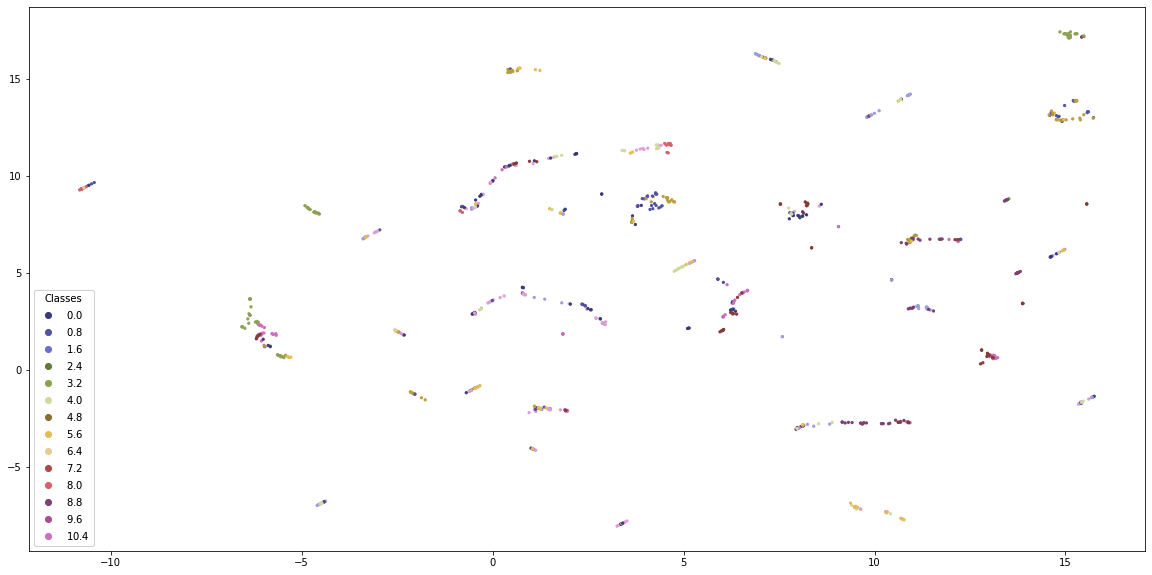

In [29]:
#Plotting the array

fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(x = embedding[0][:,0], y = embedding[0][:,1],s=5, c = clusters, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=15),
                    loc="lower left", title="Classes")
ax.add_artist(legend1);

In [32]:
#Here we are using LGBM in order to understand how useful our clusters are for classification
#If the clusters are good then they will be good

from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

lgbm_data = X.copy()
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')

clf_kp = LGBMClassifier(colsample_bytree=0.8)
cv_scores_kp = cross_val_score(clf_kp, lgbm_data, clusters, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

CV F1 score for K-Prototypes clusters is 0.6813552495665652


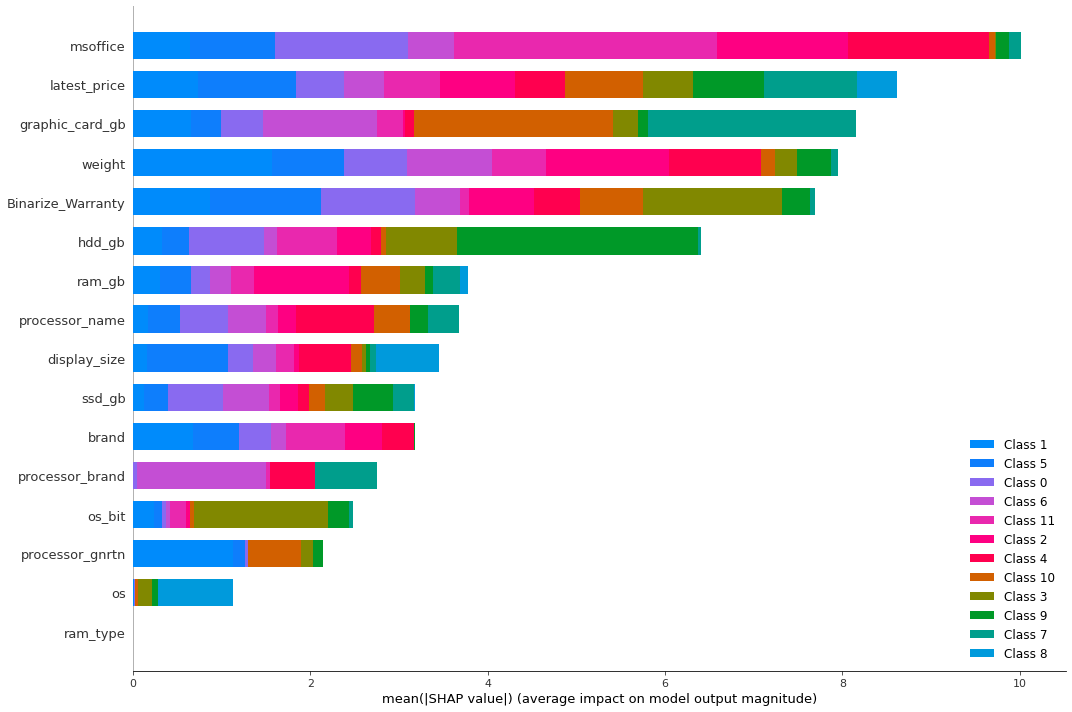

In [33]:
#We now use SHAP in order to understand the usefulness of our clusters and features
#We can understand how much impact each feature had on the classification of features and use our domain knowledge

import shap

clf_kp.fit(lgbm_data, clusters)
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(lgbm_data)
shap.summary_plot(shap_values_kp, lgbm_data, plot_type="bar", plot_size=(15, 10))

### 2.1.3 K-Prototype Thoughts

Through our clusters, we see that there are unique grouping of features that are important. The UMAP gave us some insight into the clusters. It seems like our clusters are quite sparse yet overlap meaning that it is not a simple combination of features which lead to the pricing. 

We can look at the SHAP and see that things like MS Office were very useful in the clustering. We are using `latest_price` as our target here so it is good that it shows up in many of the clusters as a powerful grouping tool. We can look at groups around a certain price to see which features are more associated with that price. Next, we have the features of `graphics_card_gb`, `weight`, `Warranty`, and `hdd_gb` showing us at the top contenders. It would seem that our K-Prototype gives us the ability to look at which features are important but does not give us strict answers to the price which we can do a bit more digging to explain.

## 2.2 Isomapping

Isomapping is a dimensionality reduction algorithm which will allow us to project/cluster the data based on groups. It uses geodesic distance not Euclidean meaning it will travel distances which connect points in a meaningful way and not just jumping gaps. Isomapping is similar to PCA in the sense that it reduces dimensionality but can be a little more challenging to interpret. It will allow us to understand how our data flows and what clusters are naturally occuring.

Since isomapping and XGBoost cannot work with categorical variables we will need to perform dummy encoding on the data before we are able to use it. 

In [35]:
#Creating dummy variable
laptop_cat = laptop_df.select_dtypes(include = 'object').columns
laptop_cat = laptop_cat.insert(0, 'os_bit')
laptop_cat

laptop_dummies = pd.get_dummies(laptop_df, columns = laptop_cat, drop_first = True)

df = laptop_dummies
df.head()

,ram_gb,ssd_gb,hdd_gb,graphic_card_gb,display_size,warranty,latest_price,Binarize_Warranty,os_bit_64,brand_APPLE,...,ram_type_DDR4,ram_type_DDR5,ram_type_LPDDR3,ram_type_LPDDR4,ram_type_LPDDR4X,os_Mac,os_Windows,weight_Gaming,weight_ThinNlight,msoffice_Yes
0,4,0,1024,0,15.6,0,324.87,0,1,0,...,1,0,0,0,0,0,1,0,1,0
1,4,0,512,0,15.6,0,254.67,0,1,0,...,1,0,0,0,0,0,1,0,0,0
2,4,128,0,0,15.6,0,259.87,0,1,0,...,1,0,0,0,0,0,1,0,1,0
3,4,128,0,0,15.6,0,279.37,0,1,0,...,1,0,0,0,0,0,1,0,1,0
4,4,256,0,0,15.6,0,324.87,0,1,0,...,1,0,0,0,0,0,1,0,1,0


In [36]:
# Might be useful to have categories like for Decision Tree for future interpretability

cuts = [150, 550, 950, 1350, 1750, 2150, 2550, 2950, 3350, 3750, 4150, 6000]
labels = ["$150-$550", "$550-$950", "$950-$1350","$1350-1750","$1750-$2150", "$2150-$2550",\
          "$2550-$2950", "$2950-$3350", "$3350-$3750", "$3750-$4150", "$4150 and up"]

df['price_cat'] = pd.cut(df['latest_price'], cuts, labels = labels)

In [38]:
#Create the dataset -> We are working with dimension reduction so no strict test/train set 

#for labels
X = df.drop(['price_cat'], axis = 1)

#Scale our X accordingly using MinMaxScaler
X_to_scale = ['ram_gb', 'ssd_gb', 'hdd_gb', 'graphic_card_gb', 'display_size', 'latest_price']

#Initialize the MinMax Scaler
X_scaled = MinMaxScaler()

#Fit the X data for our numerical columns
X_scaled.fit(X[X_to_scale])

#Transform the X data for both the X_train and X_test
X_scaled = X_scaled.transform(X[X_to_scale])

#Convert these back to dataframes so we can add them back in
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns = X_to_scale)

#Add back in the columns
#All the other columns
X_other_columns = X.columns.drop(X_to_scale)

#Join from scaled to not-scaled
X = X_scaled.join(X[X_other_columns])

y = df[['price_cat']]

### 2.2.1 2-D Isomap
First look at isomapping in two dimensions

In [61]:
#Import Isomap which is a manifold learning algortihm

from sklearn.manifold import Isomap


model = Isomap(n_neighbors = 3, n_components = 2)
model.fit(X)
manifold_2Da = model.transform(X)
manifold_2D = pd.DataFrame(manifold_2Da, columns = ['Component 1', 'Component 2'])

manifold_2D.head()

,Component 1,Component 2
0,8.342287,-1.396863
1,7.859261,0.042191
2,2.638771,1.958364
3,2.638771,1.958364
4,2.638771,1.958364


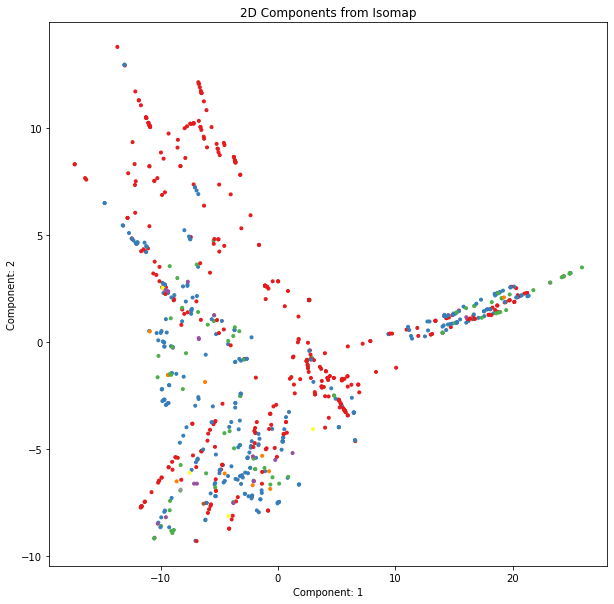

In [62]:
%matplotlib inline
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111)
ax.set_title('2D Components from Isomap')
ax.set_xlabel('Component: 1')
ax.set_ylabel('Component: 2')
plt.scatter(x = manifold_2D['Component 1'], y = manifold_2D['Component 2'], marker='.', c = X['latest_price'], cmap = 'Set1')
plt.show();


### 2.2.2 3-D Isomap
Next look at isomapping in three dimensions

In [58]:
model = Isomap(n_neighbors = 5, n_components = 3)
model.fit(X)
manifold_3Da = model.transform(X)
manifold_3D = pd.DataFrame(manifold_3Da, columns = ['Component 1', 'Component 2', 'Component 3'])

manifold_3D.shape

(896, 3)

In [59]:
X.shape

(896, 76)

<IPython.core.display.Javascript object>


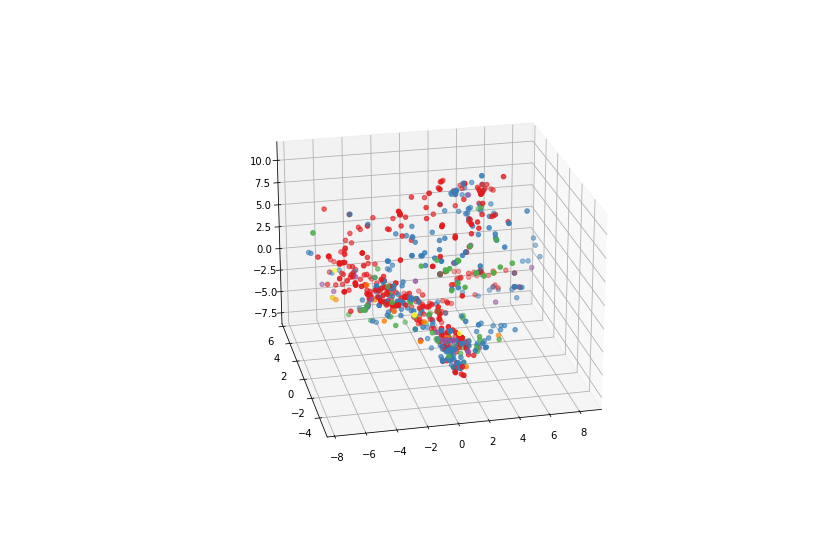

In [60]:
%matplotlib notebook

ax = plt.axes(projection = '3d')

zdata = manifold_3D['Component 1']
xdata = manifold_3D['Component 2']
ydata = manifold_3D['Component 3']
ax.scatter3D(xdata, ydata, zdata, c = df['latest_price'], cmap = 'Set1');

In [47]:
model.nbrs_

NearestNeighbors(n_neighbors=6)

### 2.2.3 Isomap Thoughts

Althought Isomap is a powerful tool for dimensionality reduction I lack the ability to unpack the deeper knowledge from the components. Additionally, it seems that a lot of our data is overlapping and sitting over each other. We would have to be quite strict with our neighboring

## XGboost and Random Forest Time

In [ ]:
#We're going to make "categories" of prices because XGBoost likes to have labels
#We will build these categories based on priced ranges, lets first look at the range of prices we have

df['latest_price'].describe()

#With a maximum price of $5745 and a minimum price of $181.87 we want to avoid too many groups
#We will first try with  groups of 400, with the last group somewhat larger



In [ ]:
df['latest_price'].sort_values(ascending = False).head()

In [ ]:
#creating our categories
cuts = [150, 550, 950, 1350, 1750, 2150, 2550, 2950, 3350, 3750, 4150, 6000]
labels = ["$150-$550", "$550-$950", "$950-$1350","$1350-1750","$1750-$2150", "$2150-$2550",\
          "$2550-$2950", "$2950-$3350", "$3350-$3750", "$3750-$4150", "$4150 and up"]

df['price_cat'] = pd.cut(df['latest_price'], cuts, labels = labels)


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()

y = df[['price_cat']]

y = encoder.fit_transform(y)

In [ ]:
#Now that we have categories we can begin the XGBoost training
import xgboost as xgb

X = df.drop(['price_cat','latest_price'], axis = 1)
#y = df[['price_cat']].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

In [ ]:
xgbr = xgb.XGBClassifier()

xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

In [ ]:
#Try to improve using Bayesian Optimization
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error

dtrain = xgb.DMatrix(X_train, y_train)

def bo_tune_xgb(max_depth, gamma, n_estimators, learning_rate):
        params = {'max_depth': int(max_depth),
                 'gamma': gamma,
                 'learning_rate': learning_rate,
                 'subsample':0.8,
                 'eta':0.1,
                 }
        cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
        return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [ ]:
xgb_bo = BayesianOptimization(bo_tune_xgb, 
                             {'max_depth': (3,10),
                             'gamma':(0,1),
                             'n_estimators': (100,120),
                             'learning_rate':(0,1)
                             })


In [ ]:
xgb_bo.maximize(n_iter = 5, init_points = 8, acq = 'ei')

In [ ]:
#Extracting the best parameters
params = xgb_bo.max['params']
print(params)

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

In [ ]:
#Initialize an XGBClassifier with the tuned parameters and fit the training data
xgbr2 = xgb.XGBClassifier(**params)
xgbr2.fit(X_train, y_train)

#predicting for training set
y_pred = xgbr2.predict(X_test)

#Looking at the classification report
print(metrics.classification_report(y_test,y_pred))

In [ ]:
%matplotlib inline
ax = xgb.plot_importance(xgbr);
fig = ax.figure
fig.set_size_inches(10,10)

In [ ]:
ax = xgb.plot_tree(xgbr, num_trees= xgbr.get_booster().best_iteration)
fig = ax.figure
fig.set_size_inches(20,20)

In [ ]:
xgb_df = xgbr.get_booster().trees_to_dataframe()
xgb_df

In [ ]:
#n-1 tree will be best iteration
xgb_best = xgb_df[xgb_df['Tree'] == 1098]
xgb_best